In [1]:
import copy
import numpy as np
import matplotlib.pyplot as plt
# PyTorch
import torch
import torch.nn as nn
import torchvision

In [2]:
import sys
sys.path.append('../src/')

%load_ext autoreload
%autoreload 2
# Importing our custom module(s)
import utils

In [3]:
normalized_train_transform = torchvision.transforms.Compose([
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Resize(size=176),
    torchvision.transforms.CenterCrop(size=224),
    torchvision.transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])
train_transform = torchvision.transforms.Compose([
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Resize(size=176),
    torchvision.transforms.CenterCrop(size=224),
])
normalized_val_transform = torchvision.transforms.Compose([
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Resize(size=232),
    torchvision.transforms.CenterCrop(size=224),
    torchvision.transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])
val_transform = torchvision.transforms.Compose([
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Resize(size=232),
    torchvision.transforms.CenterCrop(size=224),
])
normalized_train_dataset = torchvision.datasets.ImageFolder(root='/cluster/tufts/hugheslab/datasets/ImageNet/train/', transform=normalized_train_transform)
train_dataset = torchvision.datasets.ImageFolder(root='/cluster/tufts/hugheslab/datasets/ImageNet/train/', transform=train_transform)
normalized_val_dataset = torchvision.datasets.ImageFolder(root='/cluster/tufts/hugheslab/datasets/ImageNet/val/', transform=normalized_val_transform)
val_dataset = torchvision.datasets.ImageFolder(root='/cluster/tufts/hugheslab/datasets/ImageNet/val/', transform=val_transform)

In [4]:
gamma, random_state, weight_decay = 1e2, 42, 1e2
path = f'/cluster/home/eharve06/understanding-SWAG/src/random_kitchen_sinks_gamma={gamma}_weight_decay={weight_decay}_random_state={random_state}.pt'
random_kitchen_sink = torch.load(f'{path}', map_location=torch.device('cpu'))
w, b, y, m, Phi = random_kitchen_sink['w'], random_kitchen_sink['b'], random_kitchen_sink['y'], random_kitchen_sink['m'], random_kitchen_sink['Phi']

In [5]:
print(w.shape)
print(b.shape)
print(y.shape)
print(m.shape)
print(Phi.shape)

torch.Size([20, 150528])
torch.Size([20, 1])
torch.Size([100000])
torch.Size([100000, 1000])
torch.Size([20, 100000, 1000])


In [30]:
test_index = 199
xtest = torch.stack([normalized_val_dataset[test_index][0].view(-1)], dim=-1)
ztest = torch.stack([Phi[:,:,i].t() @ torch.cos(gamma * w @ xtest + b) for i in range(1_000)]).sum(dim=0)

tensor([50797, 77342, 87556, 41668,  6588])


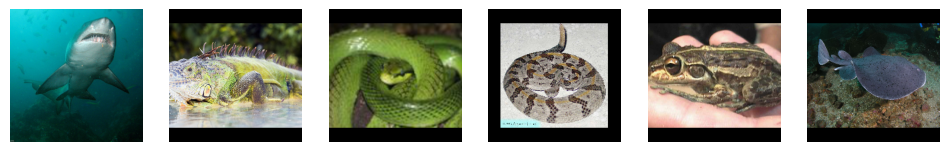

In [31]:
ncols, nrows = 6, 1
fig, axs = plt.subplots(ncols=ncols, nrows=nrows, figsize=(2*ncols, 2*nrows))
axs[0].imshow(val_dataset[test_index][0].permute(1, 2, 0))
topk = torch.topk(-1*ztest.view(-1), 5).indices
print(topk)
axs[1].imshow(train_dataset[topk[0]][0].permute(1, 2, 0))
axs[2].imshow(train_dataset[topk[1]][0].permute(1, 2, 0))
axs[3].imshow(train_dataset[topk[2]][0].permute(1, 2, 0))
axs[4].imshow(train_dataset[topk[3]][0].permute(1, 2, 0))
axs[5].imshow(train_dataset[topk[4]][0].permute(1, 2, 0))
for i in range(ncols): axs[i].axis('off')
plt.show()

In [ ]:
################################################################################
def log_matrix_determinant_lemma(A, U, V):
    # This function assumes A is a diagonal matrix, $U \in 
    #     \mathcal{R}^{n \times m}$, and m << n.
    n, m = U.shape
    A_inv = torch.diag(1/torch.diag(A))
    log_det_A = torch.log(torch.diag(A)).sum()
    return torch.log(torch.linalg.det(torch.eye(m) + V@A_inv@U))+log_det_A

def woodbury_matrix_identity(A, U, V):
    # This function assumes A is a diagonal matrix, C is the identity matrix,
    #     $U \in \mathcal{R}^{n \times m}$, and m << n.
    n, m = U.shape
    A_inv = torch.diag(1/torch.diag(A))
    C_inv = torch.eye(m)
    return A_inv - A_inv@U@torch.linalg.inv(C_inv + V@A_inv@U)@V@A_inv

D, R, num_labels = Phi.shape
label = 0
woodbury_matrix_identity(gamma**2*torch.eye(R), Phi[:,:,label].t(), Phi[:,:,label])